In [20]:
# FeatureModeling.ipynb
# Train models using engineered features from exoTrain_features.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore', category=UserWarning,module='xgboost')

In [21]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [22]:
# --- Load Feature CSVs ---
train_path = 'exoTrain_features.csv'
test_path = 'exoTest_features.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# --- Use only non-FFT features ---
top_features = [
    'avg_dip_depth', 'min_flux', 'std', 'range',
    'max_dip_duration', 'mean', 'kurtosis'
]

# --- Prepare Data ---
X_train = train_df[top_features]
y_train = (train_df['LABEL'] - 1).astype(int)
X_test = test_df[top_features]
y_test = (test_df['LABEL'] - 1).astype(int)

# --- Apply SMOTE to balance classes ---
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print(pd.Series(y_train_bal).value_counts())

# --- Train and evaluate classifiers ---
def evaluate_model(model, model_name):
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    print(f"\n--- {model_name} ---")
    print(classification_report(y_test, y_pred, target_names=["No Exoplanet", "Exoplanet"]))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Exoplanet", "Exoplanet"])
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()

Applying SMOTE...
LABEL
1    5050
0    5050
Name: count, dtype: int64



--- Logistic Regression ---
              precision    recall  f1-score   support

No Exoplanet       1.00      0.62      0.76       565
   Exoplanet       0.02      0.80      0.04         5

    accuracy                           0.62       570
   macro avg       0.51      0.71      0.40       570
weighted avg       0.99      0.62      0.76       570



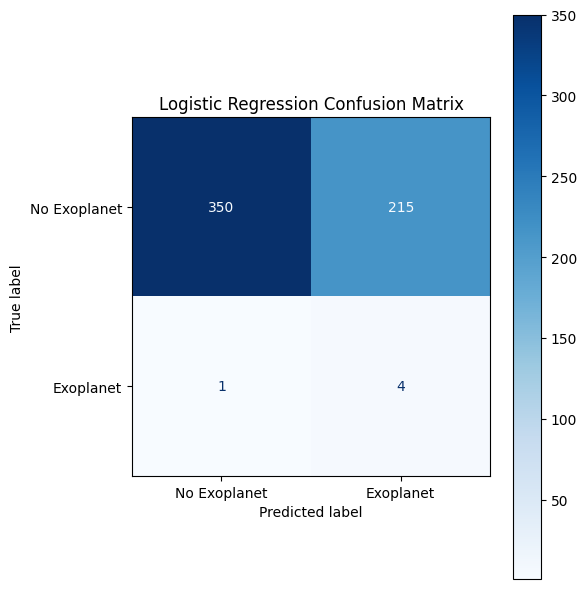


--- Decision Tree ---
              precision    recall  f1-score   support

No Exoplanet       0.99      0.97      0.98       565
   Exoplanet       0.05      0.20      0.08         5

    accuracy                           0.96       570
   macro avg       0.52      0.58      0.53       570
weighted avg       0.98      0.96      0.97       570



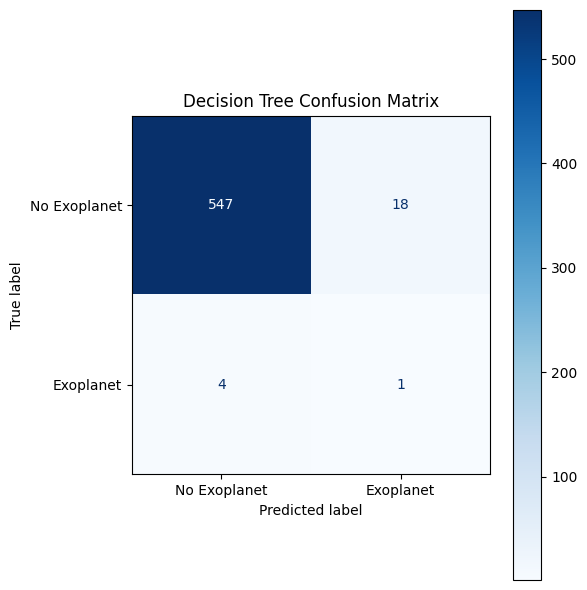


--- Random Forest Hyperparameter Tuning ---
Fitting 3 folds for each of 24 candidates, totalling 72 fits

--- Random Forest (Tuned) ---
              precision    recall  f1-score   support

No Exoplanet       0.99      0.99      0.99       565
   Exoplanet       0.20      0.40      0.27         5

    accuracy                           0.98       570
   macro avg       0.60      0.69      0.63       570
weighted avg       0.99      0.98      0.98       570



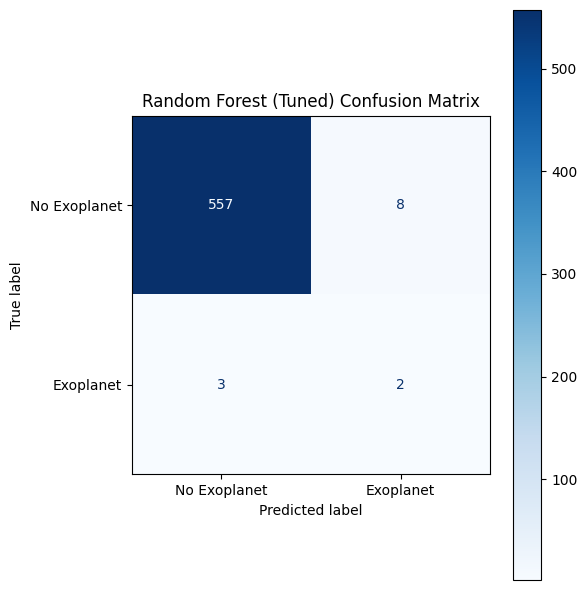


--- Feature Importance (Tuned Random Forest) ---


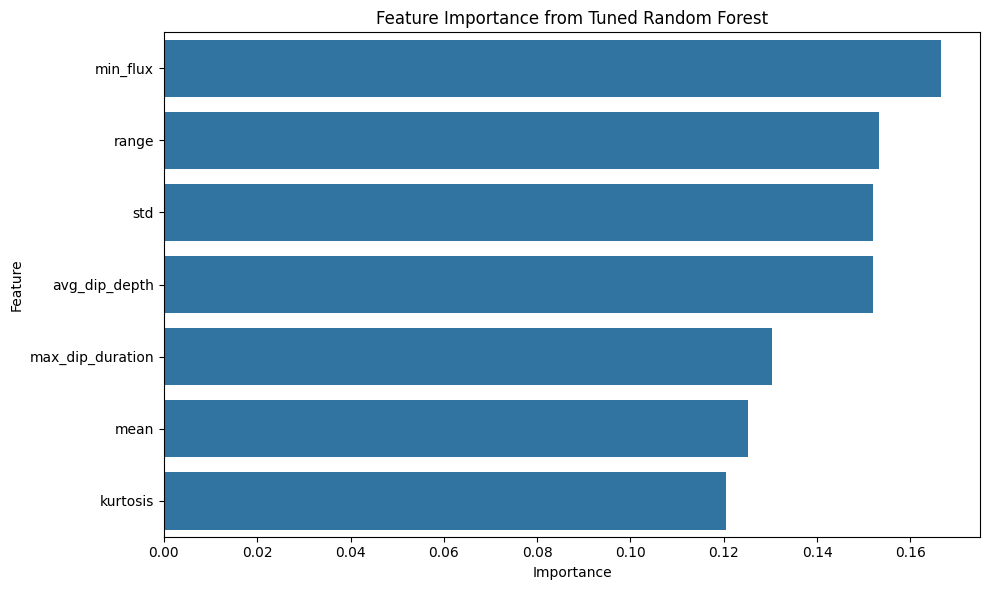


--- XGBoost Hyperparameter Tuning ---
Fitting 3 folds for each of 72 candidates, totalling 216 fits

--- XGBoost (Tuned) ---
              precision    recall  f1-score   support

No Exoplanet       0.99      0.99      0.99       565
   Exoplanet       0.22      0.40      0.29         5

    accuracy                           0.98       570
   macro avg       0.61      0.69      0.64       570
weighted avg       0.99      0.98      0.98       570



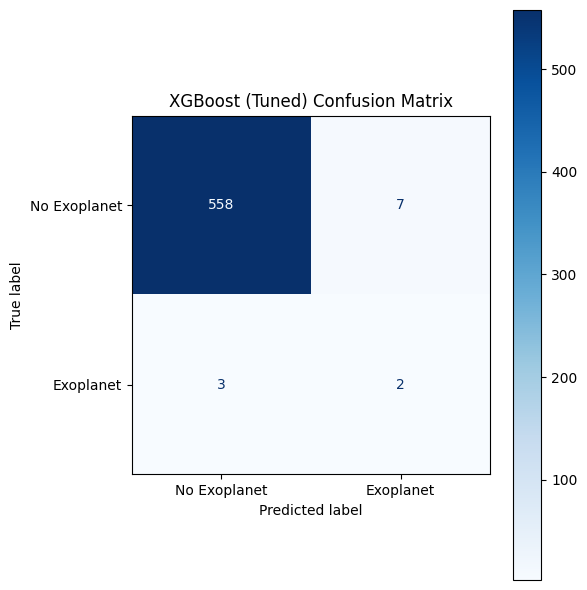

In [24]:
# Logistic Regression
evaluate_model(LogisticRegression(max_iter=1000, solver='liblinear'), "Logistic Regression")

# Decision Tree
evaluate_model(DecisionTreeClassifier(random_state=42), "Decision Tree")

# --- Random Forest with Hyperparameter Tuning ---
print("\n--- Random Forest Hyperparameter Tuning ---")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid,
                           scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_bal, y_train_bal)

best_rf = grid_search.best_estimator_
evaluate_model(best_rf, "Random Forest (Tuned)")

# --- Feature Importance from Tuned Random Forest ---
print("\n--- Feature Importance (Tuned Random Forest) ---")
importances = best_rf.feature_importances_
feat_names = X_train.columns
importance_df = pd.DataFrame({"Feature": feat_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance from Tuned Random Forest")
plt.tight_layout()
plt.show()

# --- XGBoost Classifier (Tuned) ---
print("\n--- XGBoost Hyperparameter Tuning ---")
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss', random_state=42),
                        xgb_param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_bal, y_train_bal)

best_xgb = xgb_grid.best_estimator_
evaluate_model(best_xgb, "XGBoost (Tuned)")